# Using a toy dataset to better understand SHapley Additive exPlanations (SHAP)

In [67]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from jmspack.utils import apply_scaling, JmsColors
from jmspack.ml_utils import multi_roc_auc_plot, optimize_model, plot_confusion_matrix, summary_performance_metrics_classification, plot_learning_curve, plot_decision_boundary
shap.initjs()

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold

In [11]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [31]:
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv").dropna()

In [32]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


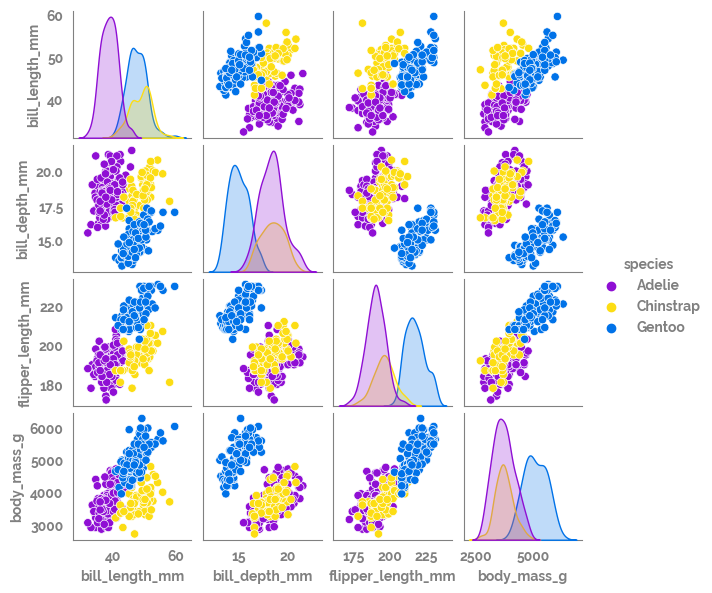

In [34]:
_ = sns.pairplot(data=df, hue="species", height=1.5)

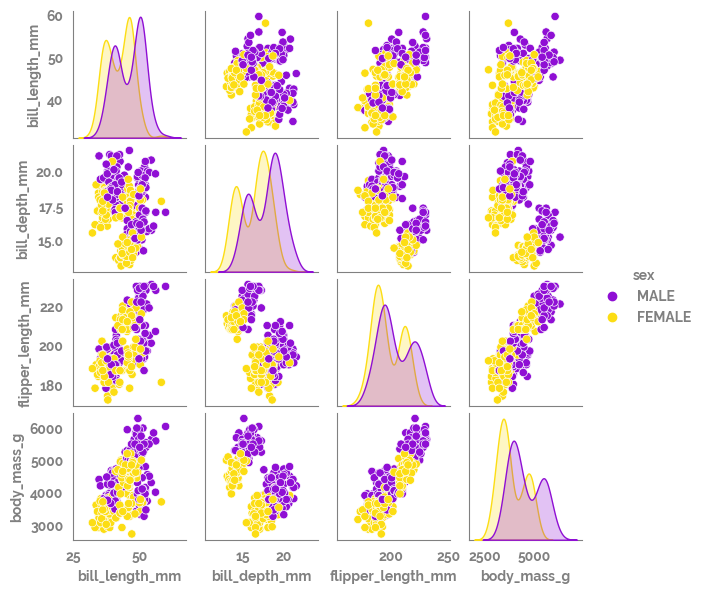

In [35]:
_ = sns.pairplot(data=df, hue="sex", height=1.5)

In [36]:
features_list = df.select_dtypes("number").columns.tolist()
target = "sex"
X = df[features_list]
y = df[target]

In [43]:
(optimized_estimator,
feature_ranking,
feature_selected,
feature_importance,
optimized_params_df,
) = optimize_model(X=X, y=y, estimator= RandomForestClassifier(),
    grid_params_dict = {
        "max_depth": [1, 2, 3, 4, 5, 10],
        "n_estimators": [10, 20, 30, 40, 50],
        "max_features": ["log2", "auto", "sqrt"],
        "criterion": ["gini", "entropy"],
    },
    gridsearch_kwargs = {"scoring": "roc_auc", "cv": 3, "n_jobs": -2},
    rfe_kwargs = {"n_features_to_select": 2, "verbose": 1})

Fitting estimator with 4 features.
Fitting estimator with 3 features.

- Sizes :
- X shape = (333, 4)
- y shape = (333,)
- X_train shape = (233, 4)
- X_test shape = (100, 4)
- y_train shape = (233,)
- y_test shape = (100,)

- Model info :
- Optimal Parameters = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
- Selected feature list = ['bill_length_mm', 'bill_depth_mm']
- Accuracy score on test set = 82.0%


In [41]:
optimized_params_df

,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
optimal_parameters,True,0.0,None,gini,5,log2,None,None,0.0,None,1,2,0.0,30,None,False,None,0,False


In [81]:
feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

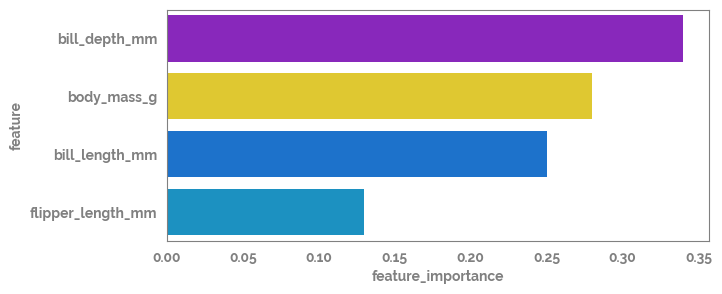

In [84]:
_ = plt.figure(figsize=(7, 3))
_ = sns.barplot(data=feature_importance_df, x="feature_importance", y="feature")

In [130]:
explainer = shap.TreeExplainer(optimized_estimator)
shap_values = explainer(X)

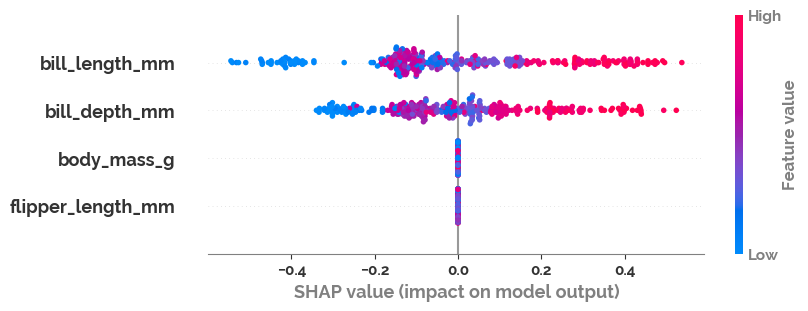

In [131]:
shap.plots.beeswarm(shap_values[:, :, 1])

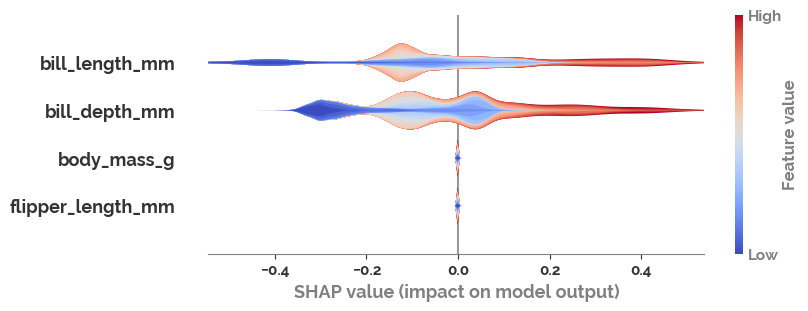

In [132]:
shap.summary_plot(shap_values[:, :, 1], X, plot_type="layered_violin", color='coolwarm')

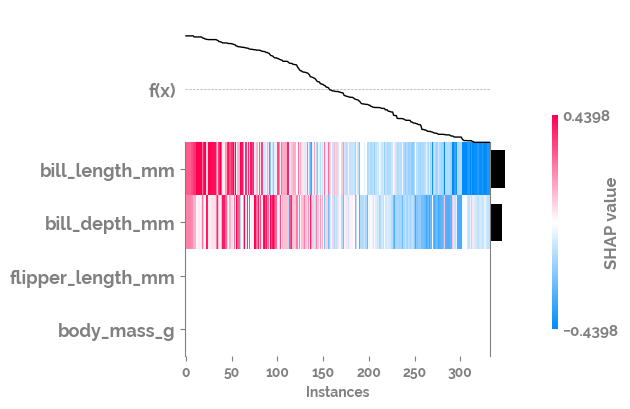

In [101]:
shap.plots.heatmap(shap_values[:, :, 1], instance_order=shap_values[:, :, 1].sum(1))

In [157]:
# shap.dependence_plot('bill_length_mm', shap_values.values[:, :, 0], X)
shap.force_plot(explainer.expected_value[0],
                shap_values.values[:, :, 0]
               )

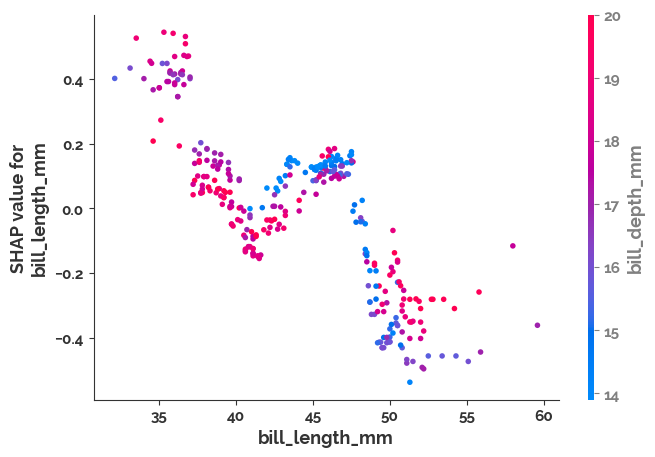

In [158]:
shap.dependence_plot('bill_length_mm', shap_values.values[:, :, 0], X)

In [161]:
# shap.plots.scatter(shap_values.values["bill_length_mm"], color=shap_values.values[:, :, 1])
shap.plots.scatter(shap_values[:,"Age"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [156]:
shap_values.values[:, :, 0]

array([[ 0.01274236, -0.2205289 ,  0.        ,  0.        ],
       [ 0.12042184,  0.15546864,  0.        ,  0.        ],
       [ 0.00328237,  0.02628778,  0.        ,  0.        ],
       ...,
       [-0.35427126, -0.07511547,  0.        ,  0.        ],
       [ 0.11823993,  0.20662545,  0.        ,  0.        ],
       [-0.41260589, -0.0530522 ,  0.        ,  0.        ]])

In [138]:
shap_values[:, :, 1]

.values =
array([[-0.01274236,  0.2205289 ,  0.        ,  0.        ],
       [-0.12042184, -0.15546864,  0.        ,  0.        ],
       [-0.00328237, -0.02628778,  0.        ,  0.        ],
       ...,
       [ 0.35427126,  0.07511547,  0.        ,  0.        ],
       [-0.11823993, -0.20662545,  0.        ,  0.        ],
       [ 0.41260589,  0.0530522 ,  0.        ,  0.        ]])

.base_values =
array([0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49924925,
       0.49924925, 0.49924925, 0.49924925, 0.49924925, 0.49

In [56]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
scoring_list = ('accuracy',
 'balanced_accuracy',
 'f1',
 'f1_weighted',
 'precision',
 'precision_weighted',
 'recall',
 'recall_weighted',
 'roc_auc',
               )

In [69]:
tmp_out = cross_validate(estimator=optimized_estimator, X=X[feature_selected], y=y.astype("category").cat.codes, groups=None, scoring=scoring_list, cv=cv, n_jobs=-1)

In [70]:
pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).agg(["mean", "median", "std"]).round(3)

,test_accuracy,test_balanced_accuracy,test_f1,test_f1_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc
mean,0.824,0.824,0.826,0.823,0.825,0.829,0.834,0.824,0.905
median,0.818,0.822,0.824,0.818,0.824,0.833,0.824,0.818,0.913
std,0.064,0.064,0.064,0.064,0.077,0.064,0.089,0.064,0.052


In [71]:
cv_metrics_df = pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).melt(var_name="Metric")

11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


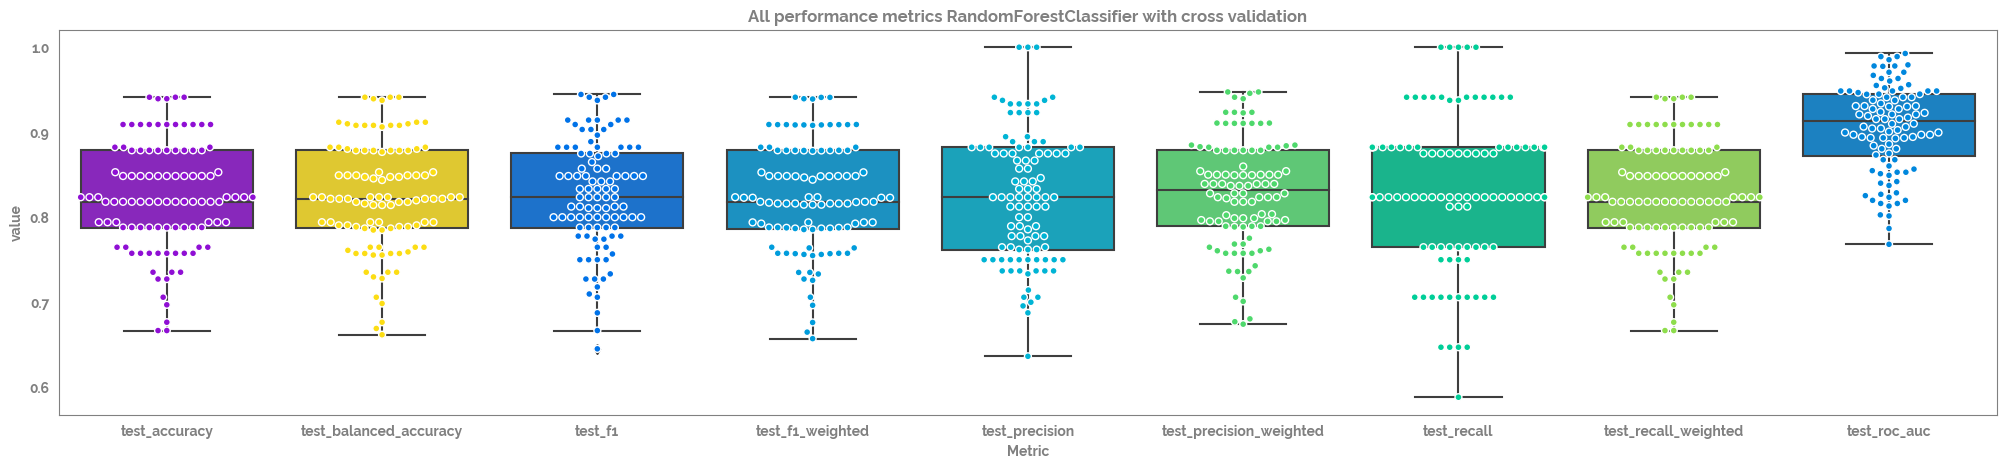

In [72]:
_ = plt.figure(figsize=(25,5))
_ = sns.boxplot(data = cv_metrics_df,
                x = "Metric",
                y = "value")
_ = sns.swarmplot(data = cv_metrics_df,
                x = "Metric",
                y = "value", edgecolor="white", linewidth=1)
_ = plt.title(f"All performance metrics {optimized_estimator.__class__.__name__} with cross validation")

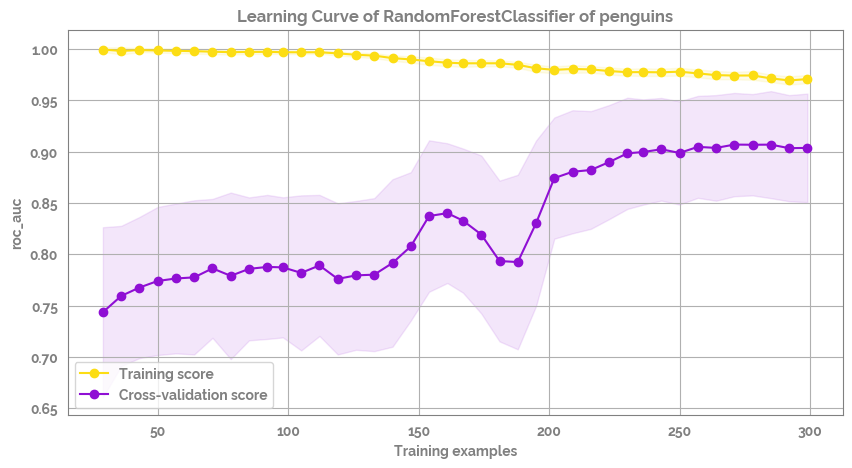

In [74]:
fig = plot_learning_curve(estimator=optimized_estimator, 
                          title=f'Learning Curve of {optimized_estimator.__class__.__name__} of penguins',
                          X=X[feature_selected], 
                          y=y,
                          groups=None, 
                          cross_color=JmsColors.PURPLE, 
                          test_color=JmsColors.YELLOW, 
                          scoring='roc_auc',
                          ylim=None, 
                          cv=cv, 
                          n_jobs=10, 
                          train_sizes=np.linspace(.1, 1.0, 40), 
                          figsize=(10,5))

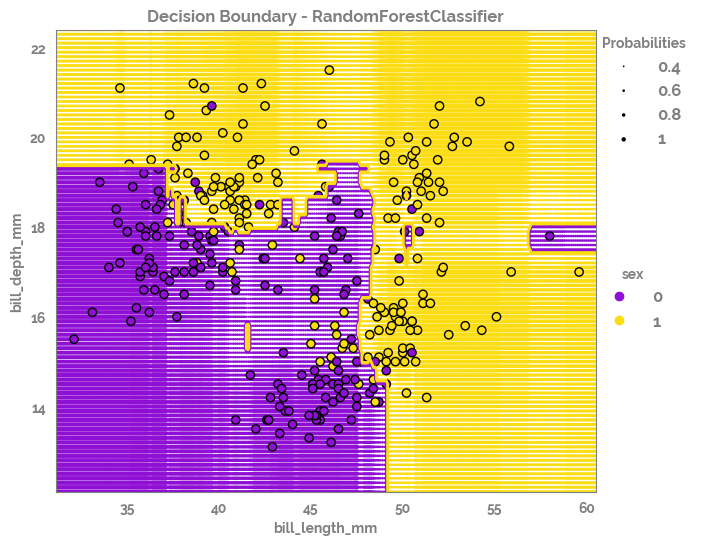

In [78]:
_ = plot_decision_boundary(X=X[feature_selected], 
                           y=y, 
                           clf=optimized_estimator, 
                           title = f'Decision Boundary - {optimized_estimator.__class__.__name__}', 
                           legend_title = target,
                          h=0.1,
                          figsize=(8, 6))